In [1]:
import os

# directory = "D:\\Code\\AI\\Model\\NumberRecognitionModel"
directory = "/Users/danielnguyen/Repo/AI/Model/numberRecognitionModel"

new_version = input("Which version is this: ")
versions_list = sorted([int(version.replace('version', '')) for version in os.listdir(directory) if version != ".DS_Store"])

try: 
    new_version = int(new_version)
except:
    latest_version = versions_list[-1]
    new_version = latest_version + 1
else:
    new_version_folder = 'version{}'.format(int(new_version))
    new_version_path = 'version{}.hdf5'.format(int(new_version))

    path = os.path.join(directory, new_version_folder)
    if versions_list.count(new_version) == 0:
        os.makedirs(path)

IndexError: list index out of range

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

%env TF_ENABLE_ONEDNN_OPTS = 1

env: TF_ENABLE_ONEDNN_OPTS=1


Using TensorFlow backend.


Found 32680 images belonging to 10 classes.
Found 8164 images belonging to 10 classes.


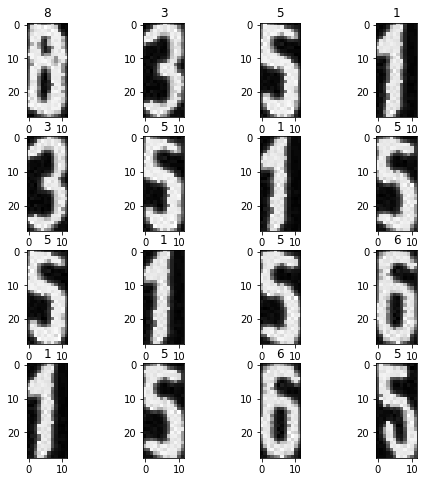

In [3]:
ds = ImageDataGenerator(
    rescale=1.0/255, 
    validation_split=0.2,
    fill_mode='constant',
    cval=0
)

train_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=16,
    subset='training',
    color_mode='grayscale',
    class_mode='sparse'
)

validation_ds = ds.flow_from_directory(
    "../numberLabel", 
    target_size=(28,12), 
    batch_size=16,
    subset='validation',
    color_mode='grayscale',
    class_mode='sparse'
)

input_shape = train_ds[0][0][0].shape

plt.rcParams["figure.figsize"] = (8,8)
fig, axs = plt.subplots(4,4)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(validation_ds[0][0][i + j], cmap='gray')
        axs[i, j].set_title(int(validation_ds[0][1][i + j]))

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((28,12,1)),
    tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3,3), activation='elu', 
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='elu', 
                        kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                        padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
            loss='sparse_categorical_crossentropy',
            metrics=[tf.keras.losses.SparseCategoricalCrossentropy(),
                    'accuracy'])

2022-02-23 14:06:39.512807: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-23 14:06:39.514358: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 4. Tune using inter_op_parallelism_threads for best performance.


In [5]:
%%writefile {path}/model.py
import tensorflow as tf

def create_model() :
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input((28,12,1)),
        tf.keras.layers.Conv2D(8, (3,3), activation='elu',
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(16, (3,3), activation='elu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(32, (3,3), activation='elu', 
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4), 
                            padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation='elu', kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                loss='sparse_categorical_crossentropy',
                metrics=[tf.keras.losses.SparseCategoricalCrossentropy(),
                        'accuracy'])

    return model

Overwriting /Users/danielnguyen/Repo/AI/Model/numberRecognitionModel/version8/model.py


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 12, 8)         80        
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 12, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 6, 8)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 6, 16)         1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 6, 16)         64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 3, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 3, 32)          4

In [7]:
class stopCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}) :
        if (logs.get('val_accuracy') >= 0.999 and logs.get('accuracy') >= 0.999) :
            print('\nReached 99% accuracy so stopping training')
            self.model.stop_training = True

save_path = os.path.join(path, new_version_path)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path,
                                                               monitor='val_accuracy',
                                                               mode='max',
                                                               save_best_only=True)

In [8]:
callback = stopCallback()

history = model.fit(train_ds, 
                    epochs=200, 
                    callbacks=[callback, model_checkpoint_callback], 
                    validation_data=validation_ds)

2022-02-23 14:06:51.359636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 255 of 2043
2022-02-23 14:07:01.351765: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 567 of 2043
2022-02-23 14:07:11.354601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 911 of 2043
2022-02-23 14:07:21.350648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1248 of 2043
2022-02-23 14:07:31.358390: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1592 of 2043
2022-02-23 14:07:41.367839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1940 of 2043
2022-02-23 14:07:44.584544: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer fi

Train for 2043 steps, validate for 511 steps
Epoch 1/200


2022-02-23 14:07:59.428730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1015 of 2043
2022-02-23 14:08:09.431746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 2008 of 2043


   2/2043 [..............................] - ETA: 7:10:34 - loss: 2.5716 - sparse_categorical_crossentropy: 2.5622 - accuracy: 0.1250 

2022-02-23 14:08:09.819346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 80s 39ms/step - loss: 0.0606 - sparse_categorical_crossentropy: 0.0509 - accuracy: 0.9873 - val_loss: 0.0171 - val_sparse_categorical_crossentropy: 0.0075 - val_accuracy: 0.9984
Epoch 2/200


2022-02-23 14:09:14.933123: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 906 of 2043
2022-02-23 14:09:24.918380: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1549 of 2043


   8/2043 [..............................] - ETA: 1:49:47 - loss: 0.0101 - sparse_categorical_crossentropy: 4.3916e-04 - accuracy: 1.0000

2022-02-23 14:09:30.583501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 85s 42ms/step - loss: 0.0182 - sparse_categorical_crossentropy: 0.0087 - accuracy: 0.9978 - val_loss: 0.0163 - val_sparse_categorical_crossentropy: 0.0070 - val_accuracy: 0.9980
Epoch 3/200


2022-02-23 14:10:39.818053: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 718 of 2043
2022-02-23 14:10:49.817665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1398 of 2043


   5/2043 [..............................] - ETA: 3:23:50 - loss: 0.0102 - sparse_categorical_crossentropy: 7.8747e-04 - accuracy: 1.0000

2022-02-23 14:10:59.570145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 91s 44ms/step - loss: 0.0169 - sparse_categorical_crossentropy: 0.0077 - accuracy: 0.9979 - val_loss: 0.0156 - val_sparse_categorical_crossentropy: 0.0066 - val_accuracy: 0.9982
Epoch 4/200


2022-02-23 14:12:10.349870: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1032 of 2043


   6/2043 [..............................] - ETA: 1:49:36 - loss: 0.0098 - sparse_categorical_crossentropy: 7.6795e-04 - accuracy: 1.0000

2022-02-23 14:12:19.495527: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 64s 31ms/step - loss: 0.0141 - sparse_categorical_crossentropy: 0.0053 - accuracy: 0.9987 - val_loss: 0.0156 - val_sparse_categorical_crossentropy: 0.0070 - val_accuracy: 0.9987
Epoch 5/200


2022-02-23 14:13:14.440902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1046 of 2043


   9/2043 [..............................] - ETA: 1:12:33 - loss: 0.0090 - sparse_categorical_crossentropy: 4.2389e-04 - accuracy: 1.0000

2022-02-23 14:13:23.462998: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 66s 32ms/step - loss: 0.0134 - sparse_categorical_crossentropy: 0.0051 - accuracy: 0.9984 - val_loss: 0.0154 - val_sparse_categorical_crossentropy: 0.0073 - val_accuracy: 0.9978
Epoch 6/200


2022-02-23 14:14:20.820923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 906 of 2043
2022-02-23 14:14:30.812660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1929 of 2043


   9/2043 [..............................] - ETA: 1:20:23 - loss: 0.0099 - sparse_categorical_crossentropy: 0.0018 - accuracy: 1.0000

2022-02-23 14:14:31.915533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 72s 35ms/step - loss: 0.0123 - sparse_categorical_crossentropy: 0.0046 - accuracy: 0.9988 - val_loss: 0.0172 - val_sparse_categorical_crossentropy: 0.0097 - val_accuracy: 0.9973
Epoch 7/200


2022-02-23 14:15:33.069625: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1041 of 2043


  10/2043 [..............................] - ETA: 1:06:24 - loss: 0.0089 - sparse_categorical_crossentropy: 0.0013 - accuracy: 1.0000   

2022-02-23 14:15:42.419631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 69s 34ms/step - loss: 0.0114 - sparse_categorical_crossentropy: 0.0040 - accuracy: 0.9989 - val_loss: 0.0163 - val_sparse_categorical_crossentropy: 0.0092 - val_accuracy: 0.9978
Epoch 8/200


2022-02-23 14:16:41.931201: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1011 of 2043


   4/2043 [..............................] - ETA: 2:51:19 - loss: 0.0972 - sparse_categorical_crossentropy: 0.0902 - accuracy: 0.9844    

2022-02-23 14:16:51.880936: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 70s 34ms/step - loss: 0.0108 - sparse_categorical_crossentropy: 0.0039 - accuracy: 0.9987 - val_loss: 0.0137 - val_sparse_categorical_crossentropy: 0.0070 - val_accuracy: 0.9985
Epoch 9/200


2022-02-23 14:17:51.914552: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 899 of 2043
2022-02-23 14:18:01.920640: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1872 of 2043


   9/2043 [..............................] - ETA: 1:23:38 - loss: 0.0094 - sparse_categorical_crossentropy: 0.0026 - accuracy: 1.0000   

2022-02-23 14:18:03.860910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2043/2043 [==============================] - 73s 36ms/step - loss: 0.0104 - sparse_categorical_crossentropy: 0.0039 - accuracy: 0.9990 - val_loss: 0.0134 - val_sparse_categorical_crossentropy: 0.0070 - val_accuracy: 0.9982
Epoch 10/200


2022-02-23 14:19:04.980024: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 979 of 2043
2022-02-23 14:19:14.983070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 1992 of 2043


   9/2043 [..............................] - ETA: 1:18:33 - loss: 0.0154 - sparse_categorical_crossentropy: 0.0091 - accuracy: 0.9931    

2022-02-23 14:19:15.498807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


2040/2043 [============================>.] - ETA: 0s - loss: 0.0092 - sparse_categorical_crossentropy: 0.0029 - accuracy: 0.9991
Reached 99% accuracy so stopping training
2043/2043 [==============================] - 70s 34ms/step - loss: 0.0091 - sparse_categorical_crossentropy: 0.0029 - accuracy: 0.9991 - val_loss: 0.0111 - val_sparse_categorical_crossentropy: 0.0050 - val_accuracy: 0.9990


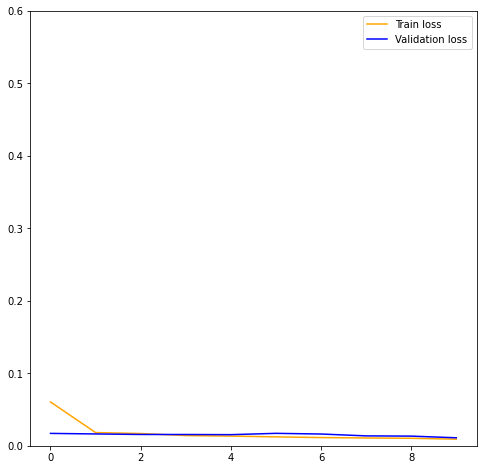

In [9]:
plt.plot(history.history['loss'], color='orange', label='Train loss')
plt.plot(history.history['val_loss'], color='blue', label='Validation loss')
plt.ylim((0, 0.6))
plt.legend()
plt.show()

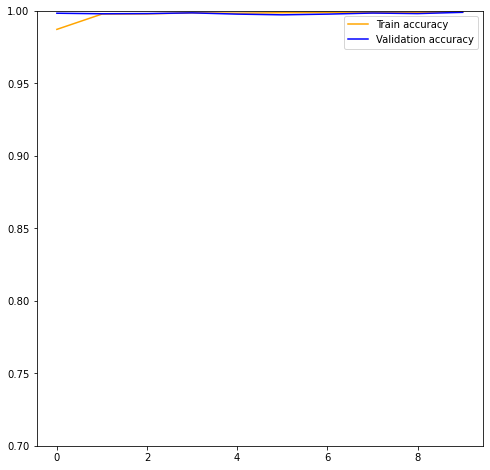

In [10]:
plt.plot(history.history['accuracy'], color='orange', label='Train accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation accuracy')
plt.ylim((0.7, 1))
plt.legend()
plt.show()

In [11]:
test_img = validation_ds[1][0][100]

import numpy as np

plt.imshow(test_img, cmap='gray')

print(np.argmax(model.predict(np.expand_dims(test_img, 0))))

IndexError: index 100 is out of bounds for axis 0 with size 16